In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import uniform, norm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import CategoricalNB, ComplementNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import svm
from XLB import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def train_all(filename_train,filename_val,selector,model_selector,name=""):
    # extract data from files
    x_train, y_train = extract_data(filename_train)
    x_val, y_val = extract_data(filename_val)

    # scale data values
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_val = scaler.transform(x_val)

    # feature selection
    feat_sel = VarianceThreshold()
    x_train = feat_sel.fit_transform(x_train)
    x_train = selector.fit_transform(x_train,y_train)
    x_val = selector.transform(feat_sel.transform(x_val))
    
    rand_seed = 3454132

    oversampler = SMOTE(sampling_strategy="not majority",random_state=rand_seed)
    x_smote, y_smote = oversampler.fit_resample(x_train,y_train)
#     print(x_smote.shape,y_smote.shape)

    oversampler = RandomOverSampler(sampling_strategy="not majority",random_state=rand_seed)
    x_os, y_os = oversampler.fit_resample(x_train,y_train)
#     print(x_os.shape,y_os.shape)
    print("{} Results:".format(name))
    print_res("Vanilla",x_train,y_train,model_selector)
    test_res("Vanilla",x_val,y_val,model_selector)
    print_res("Random Oversampling",x_os,y_os,model_selector)
    test_res("Random Oversampling",x_val,y_val,model_selector)
    print_res("SMOTE",x_smote,y_smote,model_selector)
    test_res("SMOTE",x_val,y_val,model_selector)
    

chi2 Results:
Best Score: 0.3366
bootstrap => False
criterion => entropy
max_depth => 2
min_samples_leaf => 0.3793263231610699
min_samples_split => 0.402088543425892
n_estimators => 107
warm_start => True
Splits: 5
Vanilla Train Accuracy: 34.9127%
Vanilla Validation Accuracy: 19.05%
Vanilla F1-score: 0.06
Best Score: 0.6787
bootstrap => False
criterion => entropy
max_depth => 14
min_samples_leaf => 0.013545768219276944
min_samples_split => 0.02246193690011469
n_estimators => 132
warm_start => True
Splits: 5
Random Oversampling Train Accuracy: 89.6000%
Random Oversampling Validation Accuracy: 19.05%
Random Oversampling F1-score: 0.19
Best Score: 0.5493
bootstrap => False
criterion => entropy
max_depth => 14
min_samples_leaf => 0.013545768219276944
min_samples_split => 0.02246193690011469
n_estimators => 132
warm_start => True
Splits: 5
SMOTE Train Accuracy: 86.6667%
SMOTE Validation Accuracy: 19.05%
SMOTE F1-score: 0.13
f_classif Results:
Best Score: 0.3367
bootstrap => True
criterion =

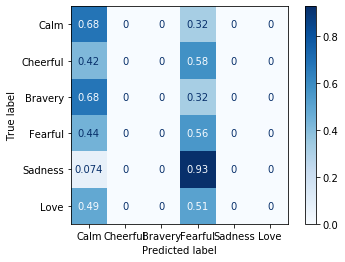

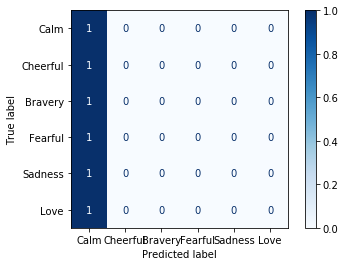

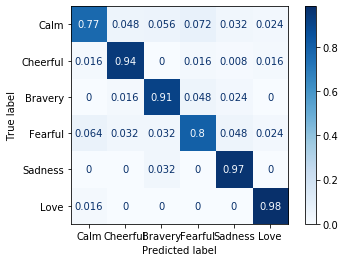

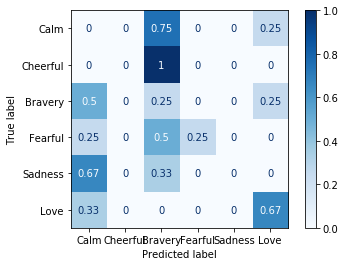

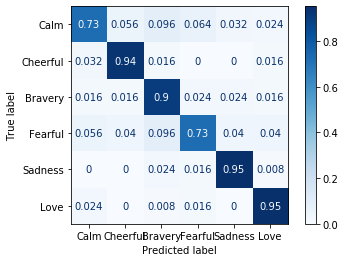

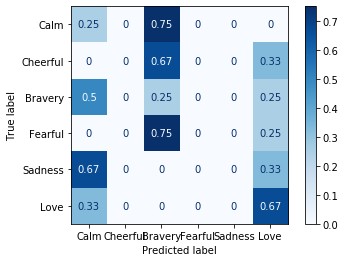

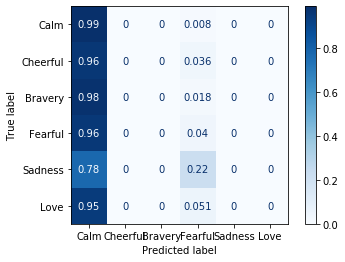

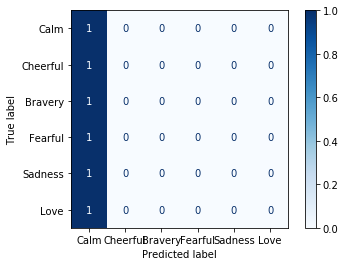

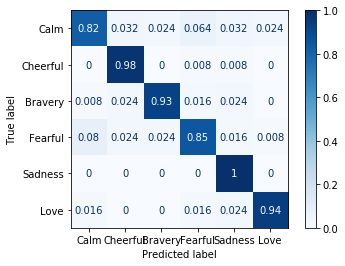

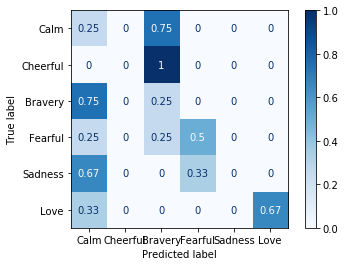

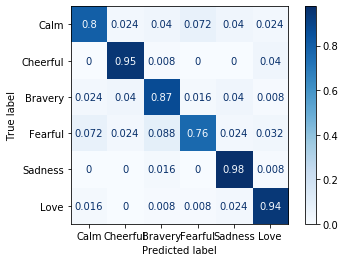

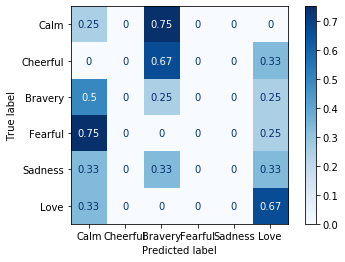

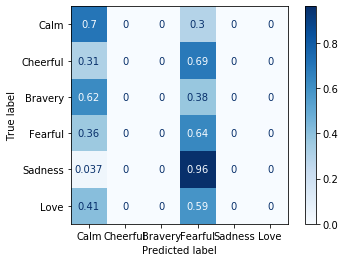

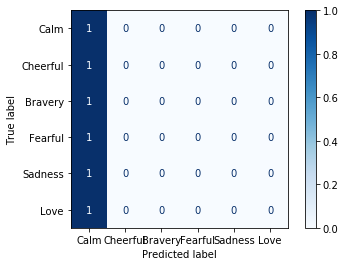

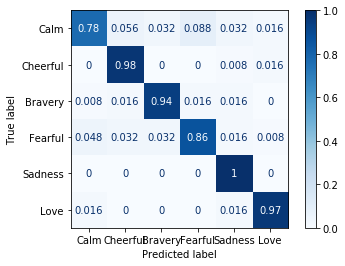

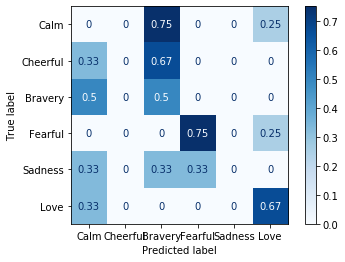

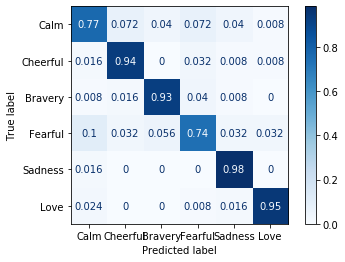

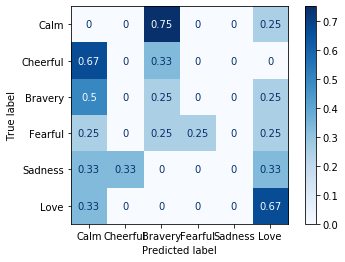

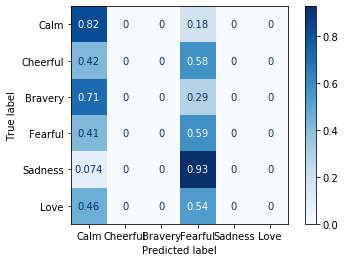

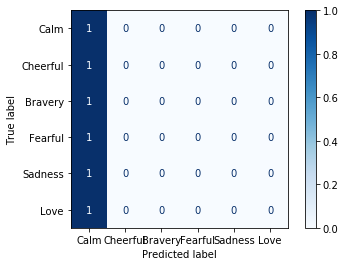

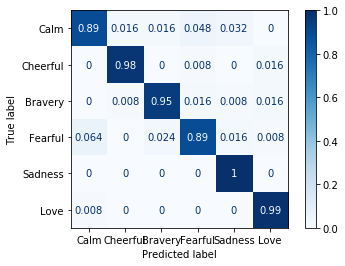

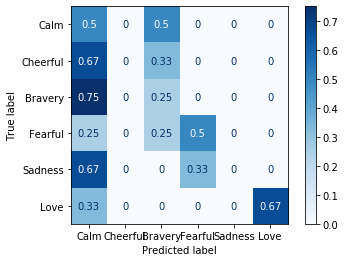

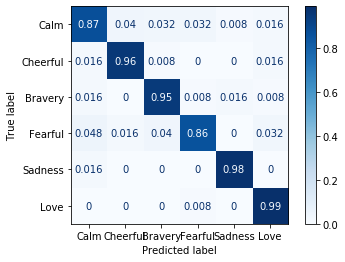

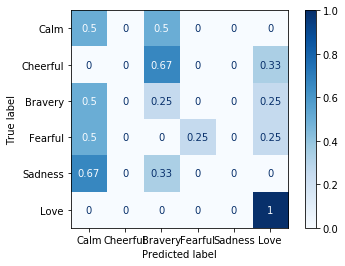

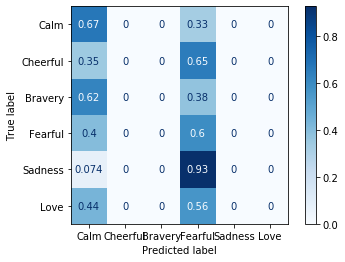

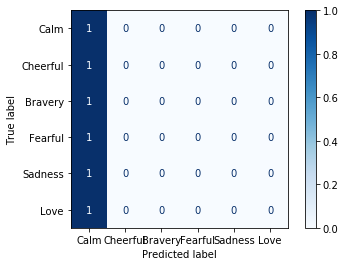

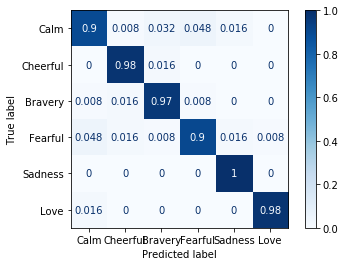

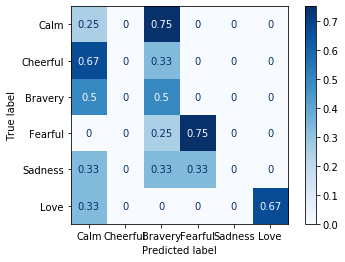

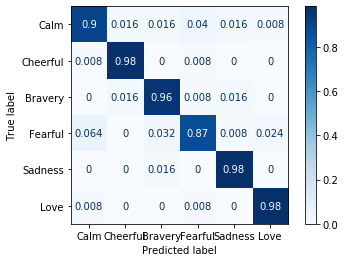

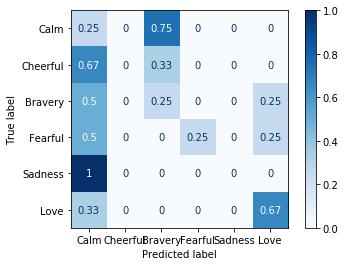

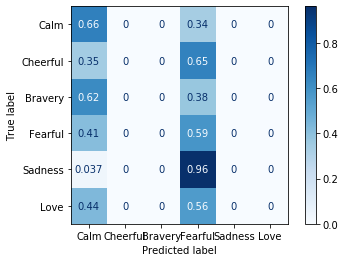

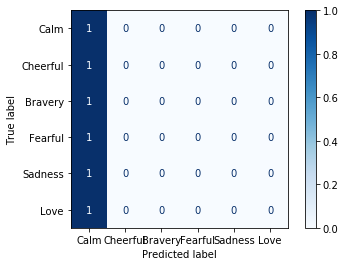

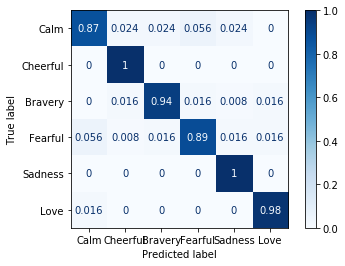

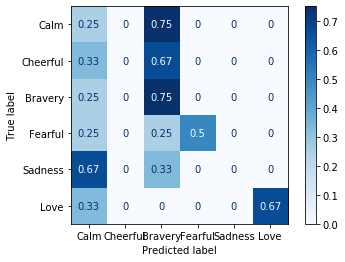

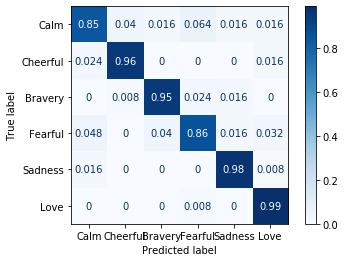

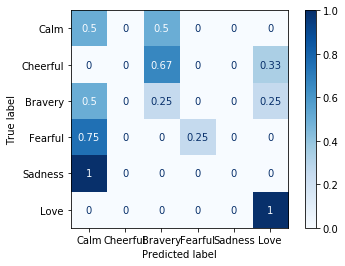

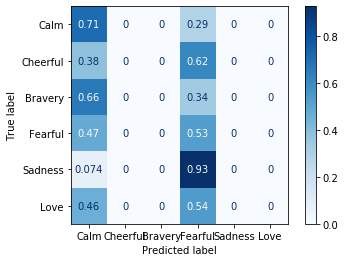

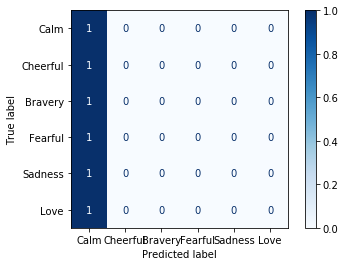

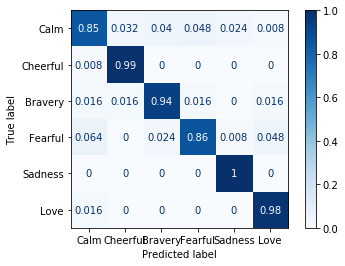

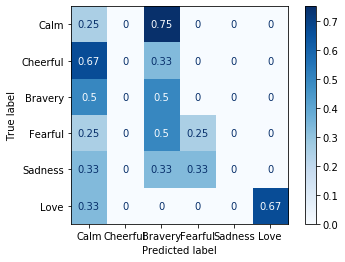

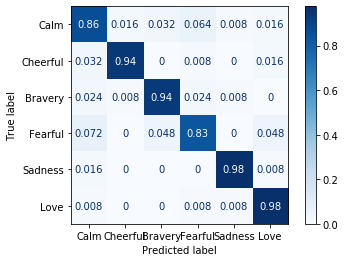

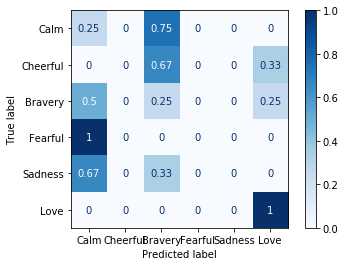

In [3]:
num_features = 45
selectors = {
    "chi2" : SelectKBest(chi2,k=num_features),
    "f_classif" : SelectKBest(f_classif,k=num_features),
    "mutual_info_classif" : SelectKBest(mutual_info_classif,k=num_features),
    "FromModel DT" : SelectFromModel(estimator=tree.DecisionTreeClassifier(random_state=481516234)),
    "RandForest" : SelectFromModel(estimator=RandomForestClassifier(n_estimators=100,random_state=481516234)),
    "LogReg" : SelectFromModel(estimator=LogisticRegression(random_state=481516234)),
    "LinearSVC" : SelectFromModel(estimator=svm.LinearSVC(C=0.25, penalty="l1", dual=False,random_state=481516234)),
}
# Random Forest
random_search_iterations = 1000
n_splits = 5
rand_seed = 108750183

parameters = {
    'n_estimators' : [i for i in range(90,151)],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [i for i in range(1,num_features + 1)],
    'min_samples_split' : uniform(loc=0.01,scale=0.99),
    'min_samples_leaf' : uniform(loc=0.01,scale=0.49),
    'bootstrap' : [True, False],
    'warm_start' : [True, False],
}

# train classifier for SMOTE data
random_forest = RandomForestClassifier(random_state=rand_seed)
random_search_random_forest = \
                        RandomizedSearchCV(random_forest, parameters,\
                                           cv=n_splits, \
                                           random_state=rand_seed, \
                                           n_iter=random_search_iterations,\
                                           n_jobs=-1)

for k,v in selectors.items():
    train_all("FinalTrainingSet.csv","Validation Set.csv",v,random_search_random_forest,k)
